# Potential carbon densities - Random Forest
Created on Jun 04 2020 //
@author: raphael ganzenmueller //
@email: raphael.ganzenmueller@geographie.uni-muenchen.de

//// dask not yet implemented (https://ml.dask.org/joblib.html)

### Initialize dask

In [1]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(job_extra=['--cluster=cm2_tiny'], 
                       queue='cm2_tiny', 
                       cores=24, 
                       processes=12,
                       memory="50 GB",
                       log_directory='./slurm_out',
                       walltime="02:00:00",
                       interface='ib0',
                       death_timeout=180,
                       scheduler_options={'dashboard_address': ':8890'}
                      )

print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e ./slurm_out/dask-worker-%J.err
#SBATCH -o ./slurm_out/dask-worker-%J.out
#SBATCH -p cm2_tiny
#SBATCH -n 1
#SBATCH --cpus-per-task=24
#SBATCH --mem=47G
#SBATCH -t 02:00:00
#SBATCH --cluster=cm2_tiny

/dss/dsshome1/lxc02/ru53log/.conda/envs/cdens_env/bin/python -m distributed.cli.dask_worker tcp://10.7.0.64:40255 --nthreads 2 --nprocs 12 --memory-limit 4.17GB --name name --nanny --death-timeout 180 --interface ib0



In [2]:
cluster.scale(jobs=4)

In [3]:
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.7.0.64:40255' processes=48 threads=96, memory=200.16 GB>

### Libraries

In [5]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
from scipy import ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import joblib

### Input and output directories

In [6]:
dir_in = '/dss/dsshome1/lxc02/ru53log/cdens/files/'
dir_out = dir_in

### Functions

In [7]:
# load data, interpolate land nans, mask land-sea, convert to dataframe
def func_prep_randomforest():
    """
    Function to load and bring data in right format to run random forest
    
    Output:
        Dataframe with all variables as columns, grid cells as rows.
    """
    
    # function to fill nans on land by nearest neighbour
    def fill_nans(data, invalid=None):
        """
        Replace the value of invalid 'data' cells (indicated by 'invalid')
        by the value of the nearest valid data cell
        From: https://stackoverflow.com/questions/5551286/filling-gaps-in-a-
        numpy
        -array

        Input:
            data:    numpy array of any dimension
            invalid: a binary array of same shape as 'data'.
                     data value are replaced where invalid is True
                     If None (default), use: invalid  = np.isnan(data)

        Output:
            Return a filled array.
        """
        if invalid is None:
            invalid = np.isnan(data)

        ind = nd.distance_transform_edt(invalid,
                                        return_distances=False,
                                        return_indices=True)
        return data[tuple(ind)]

    # load data
    hilda = xr.open_dataset(dir_in + 'hilda_area.nc')
    spawn_stbl = xr.open_dataset(dir_in + 'spawn_stable.nc')
    sgrid_stbl = xr.open_dataset(dir_in + 'sgrid_stable.nc')
    wclim = xr.open_dataset(dir_in + 'wclim_area2hilda.nc')
    sgrid17 = xr.open_dataset(dir_in + 'sgrid17_area2hilda.nc')
    sgrid20 = xr.open_dataset(dir_in + 'sgrid20_area2hilda.nc')

    # initiate dataset with hilda land sea mask and spawn stable variables
    ds_all = xr.merge(
        [hilda.mask_land_sea.to_dataset(), spawn_stbl, sgrid_stbl])

    # interpolate nan of wclim, sgrid17 and sgrid20 variables and add to ds_all
    for dataset in [wclim, sgrid17, sgrid20]:
        for var in list(dataset.keys()):
            ds_all[var] = (('lat', 'lon'),
                           fill_nans(np.array(dataset[var]),
                                     np.where(dataset[var].isnull() &
                                              ds_all.mask_land_sea == 1,
                                              True, False)))

    # convert ds_all to dataframe df_all
    df = ds_all.to_dataframe()

    # lat and lon as columns
    df = df.reset_index()

    # remove rows not being land in hilda in df_all
    df = df[df['mask_land_sea'] == 1]

    # drop land-sea mask
    df = df.drop(['mask_land_sea'], axis=1)

    return df

In [8]:
# function to run random forest
def func_randomforest(df, predict_var, expl, n_trees, max_depth,
                      test_size=0.3):
    """
    Function to run random forest algorithm

    Input:
        df_rf:     dataFrame with relevant data
        expl:      list of explanatory variable names
        n_trees:   number of trees
        test_size: test size, float between 0 and 1, default=0.3

    Output:
        Dataset with stable and predicted above and below CDs.
    """
    # data source
    dsource = predict_var[:5]

    # cover type
    ctype = predict_var[-4:]

    # create col name list of cols with stable data
    vars_stbl_list = ['spawn_stbl_crop', 'spawn_stbl_past', 'spawn_stbl_secd',
                      'spawn_stbl_prim', 'sgrid_stbl_crop', 'sgrid_stbl_past',
                      'sgrid_stbl_secd', 'sgrid_stbl_prim']

    # cols to drop from df
    vars2drop = [i for i in vars_stbl_list if i != predict_var]

    # drop all stable data cols except the one to predict
    # drop all rows with nans
    df_rf = df.drop(vars2drop, axis=1).dropna()

    # split into train and test data
    X_train, X_test, y_train, y_test = train_test_split(
        df_rf[expl].values, df_rf[predict_var].values,
        test_size=test_size, random_state=0)

    # create rf regressor
    rfr = RandomForestRegressor(n_estimators=n_trees,
                                max_depth=max_depth,
                                random_state=0,
                                n_jobs=-1)

 
    # fit rf model
    with joblib.parallel_backend('dask'):
        rfr.fit(X_train, y_train)

    # apply model at test data
    y_pred = rfr.predict(X_test)

    # variable importance
    var_imp = pd.Series(rfr.feature_importances_, index=df_rf[expl].columns)

    # predict cells without stable grid cells
    df_pred = pd.DataFrame(
        {'lat': df[['lat', *expl]].dropna().lat,
         'lon': df[['lon', *expl]].dropna().lon,
         'pcd_' + ctype: rfr.predict(df[expl].dropna().values)})

    df_pred = df_pred.set_index(['lat', 'lon'])

    # change df_pred to xarray dataset
    da_pred = df_pred.to_xarray()['pcd_' + ctype]

    # reverse latitude array
    da_pred = da_pred.sortby('lat', ascending=False)

    # statistics
    # mean absolute error, mean squared error, root mean squared error
    mabs_err = metrics.mean_absolute_error(y_test, y_pred)
    msq_err = metrics.mean_squared_error(y_test, y_pred)
    rmsq_err = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape_df = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test})
    mape_df = mape_df[mape_df.y_test != 0]
    mape = 100 * np.mean(abs(mape_df.y_pred - mape_df.y_test) / mape_df.y_test)

    # add stats to variable attributes
    da_pred.attrs['units'] = "MgC/ha"
    da_pred.attrs['Mean Absolute Error'] = round(mabs_err, 3)
    da_pred.attrs['Mean Squared Error'] = round(msq_err, 3)
    da_pred.attrs['Root Mean Squared Error'] = round(rmsq_err, 3)
    da_pred.attrs['Mean Absolute Perc. Error (MAPE)'] = round(mape, 2)
    da_pred.attrs['Accuracy (100 - MAPE)'] = round(100 - mape, 2)
    da_pred.attrs['rf_var_imp'] = str(dict(var_imp))
    da_pred.attrs['rf_parameters'] = str(rfr.get_params())

    # print stats
    print(ctype, 'stats')
    print('Mean Absolute Error:', round(mabs_err, 2))
    print('Mean Squared Error:', round(msq_err, 2))
    print('Root Mean Squared Error:', round(rmsq_err, 2))
    print('Mean Absolute Percentage Error (MAPE):', round(mape, 2), '%')
    print('Accuracy (100 - MAPE):', round(100 - mape, 2), '%')

    # export da_pred
    da_pred.encoding['zlib'] = True
    da_pred.to_netcdf(dir_out + 'rf_' + dsource + '_' + ctype + '.nc')

### Prepare dataframe and define variables

In [9]:
df_all = func_prep_randomforest()

# define explanatory variables
expl_vars = ['wc2.1_30s_elev',
       'wc2.1_30s_bio_1', 'wc2.1_30s_bio_10', 'wc2.1_30s_bio_11',
       'wc2.1_30s_bio_12', 'wc2.1_30s_bio_13', 'wc2.1_30s_bio_14',
       'wc2.1_30s_bio_15', 'wc2.1_30s_bio_16', 'wc2.1_30s_bio_17',
       'wc2.1_30s_bio_18', 'wc2.1_30s_bio_19', 'wc2.1_30s_bio_2',
       'wc2.1_30s_bio_3', 'wc2.1_30s_bio_4', 'wc2.1_30s_bio_5',
       'wc2.1_30s_bio_6', 'wc2.1_30s_bio_7', 'wc2.1_30s_bio_8',
       'wc2.1_30s_bio_9', 'bdticm', 'cec', 'cfvo', 'clay', 'nitrogen', 'ocd',
       'phh2o', 'sand', 'silt', 'soc']

# alternative variable selection for faster run
expl_test = ['bdticm', 'elev']

### Run random forest

In [ ]:
# vegetation, stable for testing
# func_randomforest(df=df_all, predict_var='spawn_stbl_secd', 
#                  expl=expl_vars, n_trees=100, max_depth=10)

In [12]:
# run random forest function for crop, pasture, secondary, primary
predict_var_list = ['spawn_stbl_crop', 'spawn_stbl_past', 
                    'spawn_stbl_secd', 'spawn_stbl_prim', 
                    'sgrid_stbl_crop', 'sgrid_stbl_past',
                    'sgrid_stbl_secd', 'sgrid_stbl_prim']

for i in predict_var_list:
    func_randomforest(df=df_all, 
                      predict_var=i, 
                      expl=expl_vars,
                      n_trees=100, 
                      max_depth=20)

crop stats
Mean Absolute Error: 0.23
Mean Squared Error: 0.13
Root Mean Squared Error: 0.36
Mean Absolute Percentage Error (MAPE): 35.46 %
Accuracy (100 - MAPE): 64.54 %
past stats
Mean Absolute Error: 0.31
Mean Squared Error: 0.2
Root Mean Squared Error: 0.45
Mean Absolute Percentage Error (MAPE): 8.12 %
Accuracy (100 - MAPE): 91.88 %
secd stats
Mean Absolute Error: 17.31
Mean Squared Error: 525.59
Root Mean Squared Error: 22.93
Mean Absolute Percentage Error (MAPE): 15.06 %
Accuracy (100 - MAPE): 84.94 %
prim stats
Mean Absolute Error: 14.93
Mean Squared Error: 373.35
Root Mean Squared Error: 19.32
Mean Absolute Percentage Error (MAPE): 11.18 %
Accuracy (100 - MAPE): 88.82 %
crop stats
Mean Absolute Error: 0.07
Mean Squared Error: 0.08
Root Mean Squared Error: 0.29
Mean Absolute Percentage Error (MAPE): 0.12 %
Accuracy (100 - MAPE): 99.88 %
past stats
Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.06
Mean Absolute Percentage Error (MAPE): 0.01 %
Accuracy 

## Plot results

In [13]:
%matplotlib inline

In [14]:
import matplotlib.pyplot as plt

In [29]:
# function to plot map of rf results
def func_plot_pcd(cdtype, covertype):
    da = xr.open_dataset(
        dir_out + 'rf_' + cdtype + '_' + covertype + '.nc')
    da_plot = da['pcd_' + covertype].plot()
    return da_plot

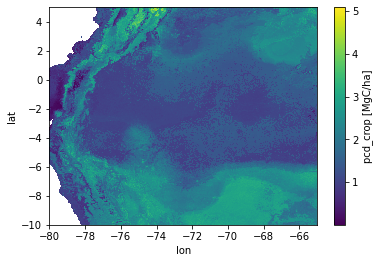

In [30]:
func_plot_pcd('spawn', 'crop')

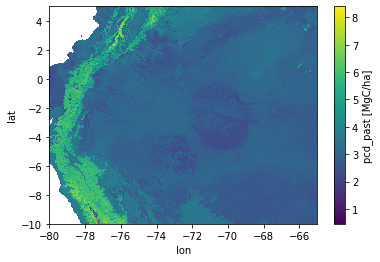

In [31]:
func_plot_pcd('spawn', 'past')

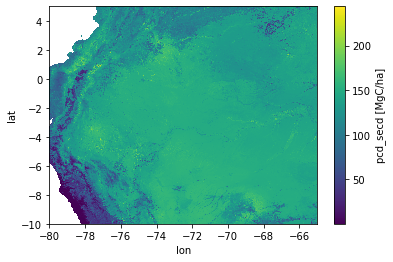

In [32]:
func_plot_pcd('spawn', 'secd')

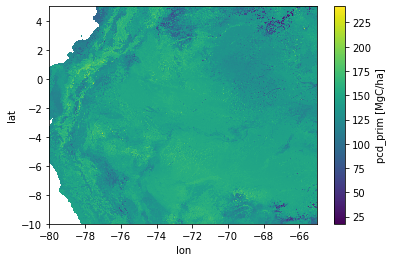

In [33]:
func_plot_pcd('spawn', 'prim')

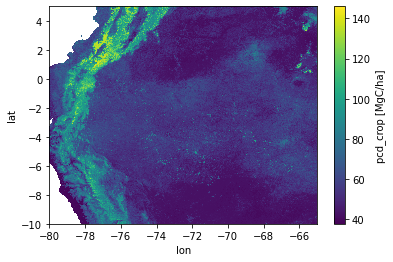

In [34]:
func_plot_pcd('sgrid', 'crop')

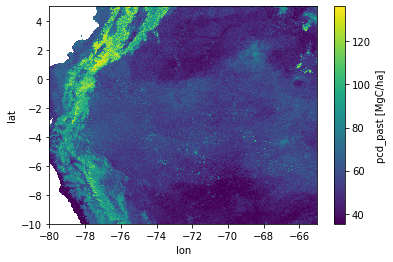

In [35]:
func_plot_pcd('sgrid', 'past')

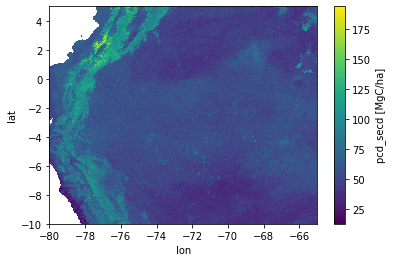

In [36]:
func_plot_pcd('sgrid', 'secd')

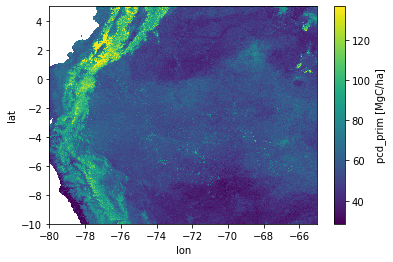

In [37]:
func_plot_pcd('sgrid', 'prim')